In [1]:
# Author: Meduri Venkata Shivaditya

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from scipy.stats import norm, multivariate_normal

try:
    import bayes_logistic  # pip install -qq bayes_logistic
except ModuleNotFoundError:
    %pip install -qq bayes_logistic
    import bayes_logistic  # pip install -qq bayes_logistic
import warnings

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

warnings.filterwarnings("ignore", category=RuntimeWarning)

Note: you may need to restart the kernel to use updated packages.


In [2]:
pml.latexify(width_scale_factor=2, fig_height=2)

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


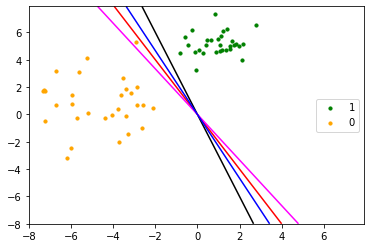

In [3]:
np.random.seed(135)

# Creating data
N = 30
D = 2
mu1 = np.hstack((np.ones((N, 1)), 5 * np.ones((N, 1))))
mu2 = np.hstack((-5 * np.ones((N, 1)), np.ones((N, 1))))
class1_std = 1
class2_std = 1.1
X_1 = np.add(class1_std * np.random.randn(N, 2), mu1)
X_2 = np.add(2 * class2_std * np.random.randn(N, 2), mu2)
X = np.vstack((X_1, X_2))
t = np.vstack((np.ones((N, 1)), np.zeros((N, 1))))

# Plotting data
x_1, y_1 = X[np.where(t == 1)[0]].T
x_2, y_2 = X[np.where(t == 0)[0]].T
plt.figure(0)
plt.scatter(x_1, y_1, c="green", s=10, marker="o", label=1)
plt.scatter(x_2, y_2, c="orange", s=10, marker="o", label=0)
plt.legend(loc="center right")

# Plotting Predictions
alpha = 100
Range = 8
step = 0.1
xx, yy = np.meshgrid(np.arange(-Range, Range, step), np.arange(-Range, Range, step))
[n, n] = xx.shape
W = np.hstack((xx.reshape((n * n, 1)), yy.reshape((n * n, 1))))
Xgrid = W
ws = np.array([[3, 1], [4, 2], [5, 3], [7, 3]])
col = ["black", "red", "magenta", "blue"]
for ii in range(ws.shape[0]):
    w = ws[ii][:]
    pred = 1.0 / (1 + np.exp(np.dot(-Xgrid, w)))
    plt.contour(xx, yy, pred.reshape((n, n)), 1, colors=col[ii])
# plt.title("Data")
pml.savefig("logreg_laplace_data")
plt.show()

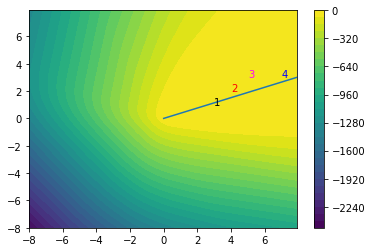

In [4]:
# Plot prior, likelihood, posterior

Xt = np.transpose(X)
f = np.dot(W, Xt)
log_prior = np.log(multivariate_normal.pdf(W, cov=(np.identity(D)) * alpha))
log_like = np.dot(np.dot(W, Xt), t) - np.sum(np.log(1 + np.exp(f)), 1).reshape((n * n, 1))
log_joint = log_like.reshape((n * n, 1)) + log_prior.reshape((n * n, 1))

# Plotting log-prior
# plt.figure(1)
# plt.contour(xx, yy, -1*log_prior.reshape((n,n)), 30, cmap="magma")
# plt.title("Log-Prior")

plt.figure(1)
ctr = plt.contourf(
    xx,
    yy,
    log_like.reshape((n, n)),
    30,
)

# Plotting points corresponding to chosen lines
for ii in range(0, ws.shape[0]):
    w = np.transpose(ws[ii, :])
    plt.annotate(str(ii + 1), xy=(w[0], w[1]), color=col[ii])

j = np.argmax(log_like)
wmle = W[j, :]
slope = wmle[1] / wmle[0]
# plt.axline([wmle[0], wmle[1]], slope=slope)
plt.plot([0, 7.9], [0, 7.9 * slope])
plt.colorbar(ctr)
# plt.title("Log likelihood")
pml.savefig("logreg_laplace_logLik")
plt.show()

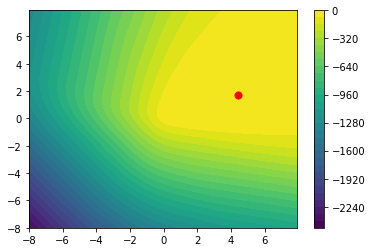

In [5]:
# Plotting the log posterior(Unnormalised)
plt.figure(2)
ctr = plt.contourf(xx, yy, log_joint.reshape((n, n)), 30, cmap="viridis")
j2 = np.argmax(log_joint)
wb = W[j2][:]
plt.scatter(wb[0], wb[1], c="red", s=50)
plt.colorbar(ctr)
# plt.title("Log-unnormalised posterior")
pml.savefig("logreg_laplace_unnormalised_posterior")
plt.show()

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


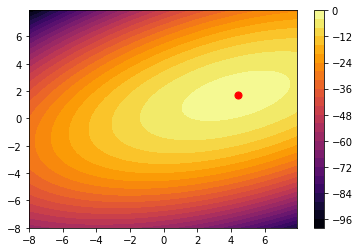

In [6]:
# Plotting the Laplace approximation to posterior
plt.figure(3)
# https://bayes-logistic.readthedocs.io/en/latest/usage.html
# Visit the website above to access the source code of bayes_logistic library
# parameter info : bayes_logistic.fit_bayes_logistic(y, X, wprior, H, weights=None, solver='Newton-CG', bounds=None, maxiter=100)
wfit, hfit = bayes_logistic.fit_bayes_logistic(
    t.reshape((N * D)),
    X,
    np.zeros(D),
    ((np.identity(D)) * 1 / alpha),
    weights=None,
    solver="Newton-CG",
    bounds=None,
    maxiter=100,
)
co = np.linalg.inv(hfit)
# wfit represents the posterior parameters (MAP estimate)
# hfit represents the posterior Hessian  (Hessian of negative log posterior evaluated at MAP parameters)
log_laplace_posterior = np.log(multivariate_normal.pdf(W, mean=wfit, cov=co))
ctr = plt.contourf(xx, yy, log_laplace_posterior.reshape((n, n)), 30, cmap="inferno")
plt.scatter(wb[0], wb[1], c="red", s=50)
plt.colorbar(ctr)
# plt.title("Laplace approximation to posterior")
pml.savefig("logreg_laplace_posterior")
plt.show()

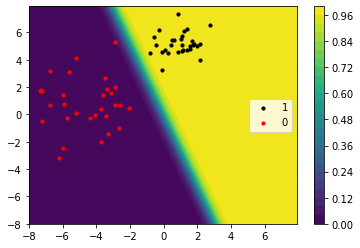

In [18]:
# Plotting the predictive distribution for logistic regression
plt.figure(5)
pred = 1.0 / (1 + np.exp(np.dot(-Xgrid, wfit)))
ctr = plt.contourf(xx, yy, pred.reshape((n, n)), 30)
x_1, y_1 = X[np.where(t == 1)[0]].T
x_2, y_2 = X[np.where(t == 0)[0]].T
plt.scatter(x_1, y_1, c="black", s=10, marker="o", zorder=2.5, label="1")
plt.scatter(x_2, y_2, c="red", s=10, marker="o", zorder=2.5, label="0")
plt.legend(loc="right")
plt.colorbar(ctr)
# plt.title(r"$p(y=1|x, w_{MAP})$")
pml.savefig("logreg_laplace_prediction_plugin")
plt.show()

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


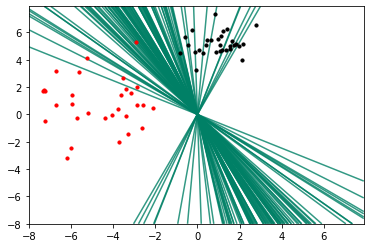

In [36]:
# Decision boundary for sampled w
plt.figure(6)
plt.scatter(x_1, y_1, c="black", s=10, marker="o", zorder=2.5)
plt.scatter(x_2, y_2, c="red", s=10, marker="o", zorder=2.5)
predm = np.zeros((n * n, 1))
s = 100
for i in range(s):
    wsamp = np.random.multivariate_normal(mean=wfit, cov=co)
    pred = 1.0 / (1 + np.exp(np.dot(-Xgrid, wsamp)))
    predm = np.add(predm, pred.reshape((n * n, 1)))
    ctr = plt.contour(xx, yy, pred.reshape((n, n)), np.array([0.5]), cmap="summer", alpha=0.8)

# plt.title("Decision boundary for sampled w")
pml.savefig("logreg_laplace_prediction_samples")
plt.show()

In [28]:
pred.shape

(25600,)

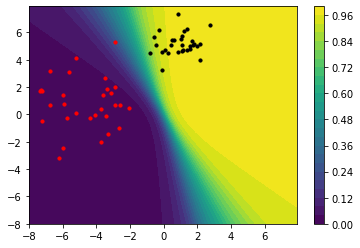

In [21]:
# MC
plt.figure(7)
predm = predm / s
ctr = plt.contourf(xx, yy, predm.reshape((n, n)), 30)
plt.scatter(x_1, y_1, c="black", s=10, marker="o", zorder=2.5)
plt.scatter(x_2, y_2, c="red", s=10, marker="o", zorder=2.5)
plt.colorbar(ctr)
# plt.title(r"MC approx of $p(y=1|x)$")
pml.savefig("logreg_laplace_prediction_mc")
plt.show()

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


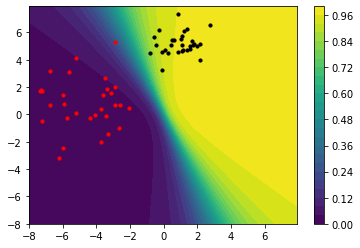

In [26]:
# Numerical
plt.figure(8)
plt.scatter(x_1, y_1, c="black", s=10, marker="o", zorder=2.5)
plt.scatter(x_2, y_2, c="red", s=10, marker="o", zorder=2.5)
pr = bayes_logistic.bayes_logistic_prob(Xgrid, wfit, hfit)
ctr = plt.contourf(xx, yy, pr.reshape((n, n)), 30)
plt.colorbar(ctr)
# plt.title(r"Deterministic approx of $p(y=1|x)$")
pml.savefig("logreg_laplace_prediction_probit")
plt.show()